In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,headline,label
0,cock suck before you piss around on my work,-1
1,you are gay or antisemmitian archangel white ...,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [4]:
df['label'].unique()

array([-1,  0])

In [5]:
def perform_data_manipulation():
  df = pd.read_csv("dataset.csv")
  for index in df.index:
    if df.loc[index, "label"] == -1:
      df.loc[index, "label"] = 1
  return df

In [6]:
df = perform_data_manipulation()

In [7]:
df.head()

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [8]:
df["label"].unique()

array([1, 0])

In [9]:
def performdatadistribution(df):
  total = df.shape[0]
  num_non_toxic = df[df['label'] == 0].shape[0]

  slices = [num_non_toxic/total, (total - num_non_toxic)/total]

  labeling = ['Non-Toxic', 'Toxic']

  explode = [0.2, 0]

  plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor' : 'black'})

  plt.title('Number of Toxic Vs Non - Toxic Test Sample')

  plt.tight_layout()

  plt.show()

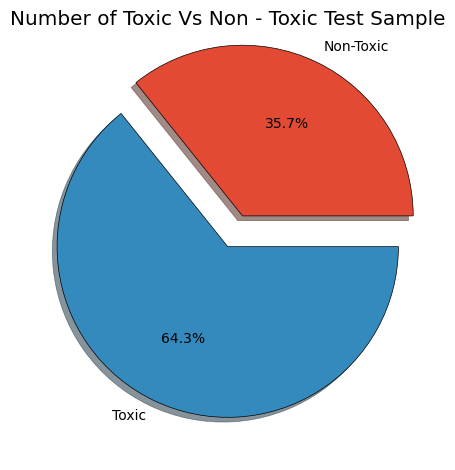

In [10]:
performdatadistribution(df)

In [11]:
def remove_pattern(input_txt, pattern):
  if (type(input_txt)==str):
    r = re.findall(pattern, input_txt)
    for i in r:
      input_txt = re.sub(i, '', input_txt)
    return input_txt
  else:
    return ""

In [12]:
df.head(1)

,headline,label
0,cock suck before you piss around on my work,1


In [13]:
# Ensure required downloads for NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')  # Additional WordNet data

def remove_pattern(input_txt, pattern):
    return re.sub(pattern, '', input_txt)

def datasetCleaning(df):
    # Check if 'headline' column exists
    if 'headline' not in df.columns:
        raise KeyError("Column 'headline' does not exist in the DataFrame.")

    # Add length of headline
    df['length_headline'] = df['headline'].str.len()

    # Duplicate rows by concatenating the DataFrame with itself
    combined_df = pd.concat([df, df], ignore_index=True)

    # Remove @user mentions
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")

    # Remove non-alphabetic characters, keeping only letters and hashtags
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)

    # Remove words with less than 3 characters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

    # Calculate the length of the cleaned tweet
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()

    # Tokenize and lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])

    # Join the tokens back into strings
    combined_df['tidy_tweet'] = tokenized_tweet.apply(lambda x: ' '.join(x))

    return combined_df, df


[nltk_data] Downloading package wordnet to /Users/sejal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/sejal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
combined_df, df = datasetCleaning(df)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")

    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()

    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)

    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))

    testing_data = tfidfvector.transform(X_test.values.astype('U'))

    filename = 'tfidfvectoizer.pkl'

    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))

    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [17]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 36296
Number of rows in the train dataset: 29036
Number of rows in the test dataset: 7260


/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


In [18]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [19]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]

    size = len(y_train)

    results = {}

    final_result = []

    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__

        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()

        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))

        results['Training Time'] = end - start

        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()

        results['Prediction Time'] = end - start

        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)

        results['F1 Score : Test'] = f1_score(y_test, prediction_test)
        results['F1 Score : Train'] = f1_score(y_train, prediction_train)

        results['Precision : Test'] = precision_score(y_test, prediction_test)
        results['Precision : Train'] = precision_score(y_train, prediction_train)

        results['Recall : Test'] = recall_score(y_test, prediction_test)
        results['Recall : Train'] = recall_score(y_train, prediction_train)

        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")

        final_result.append(results.copy())
    return final_result

In [20]:
final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.09482598304748535 sec
Training Time : LogisticRegression


/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training LogisticRegression finished in 0.45375490188598633 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.003690004348754883 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 2.204361915588379 sec
Training Time : AdaBoostClassifier
Training AdaBoostClassifier finished in 1.8676161766052246 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 15.932188034057617 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.019440889358520508 sec


In [21]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)

    return results

In [22]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,2.204362,0.021468,0.973416,0.996384,0.979596,0.997186,0.972094,0.995665,0.987215,0.998712
1,BaggingClassifier,15.932188,0.239744,0.967355,0.994249,0.974811,0.995520,0.972434,0.994960,0.977200,0.996081
2,LinearSVC,0.094826,0.000977,0.963636,0.987808,0.971855,0.990488,0.972477,0.991554,0.971234,0.989425
3,LogisticRegression,0.453755,0.000799,0.936639,0.961083,0.950728,0.969576,0.955848,0.972614,0.945664,0.966558
4,SGDClassifier,0.019441,0.000733,0.933747,0.957260,0.948196,0.966471,0.958624,0.972911,0.937993,0.960116
5,MultinomialNB,0.003690,0.002475,0.897796,0.926367,0.924440,0.944462,0.885313,0.915035,0.967185,0.975844
6,AdaBoostClassifier,1.867616,0.531560,0.838567,0.839027,0.861466,0.860519,0.967348,0.968886,0.776476,0.773955


In [23]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.003690,0.000733,0.838567,0.839027,0.861466,0.860519,0.885313,0.915035,0.776476,0.773955
max,15.932188,0.531560,0.973416,0.996384,0.979596,0.997186,0.972477,0.995665,0.987215,0.998712


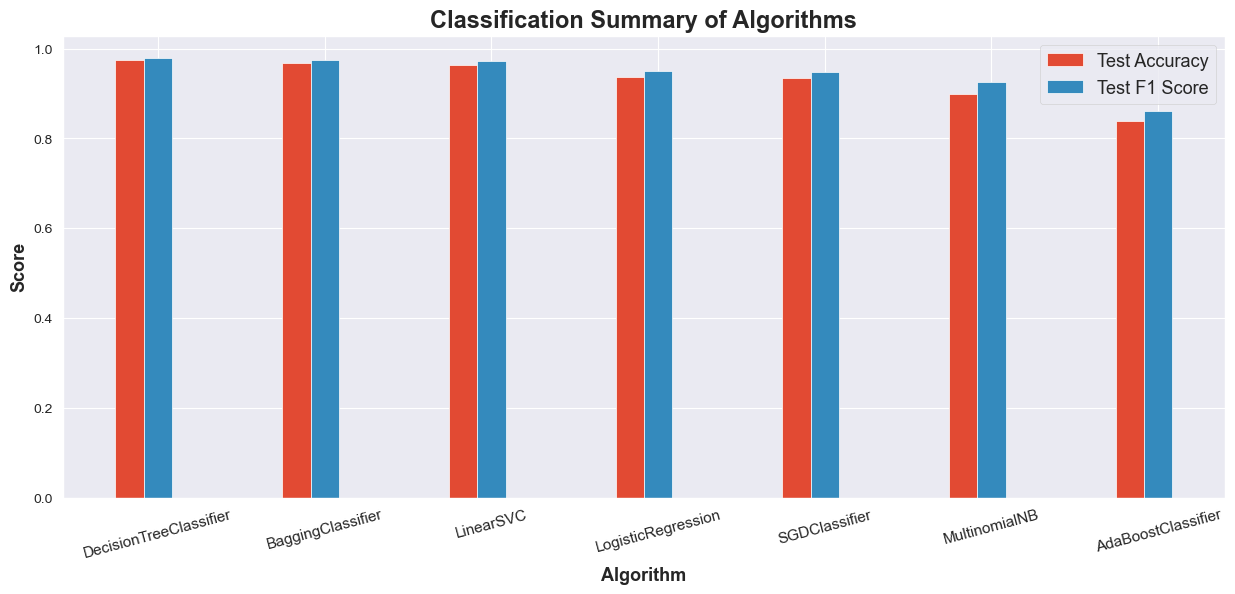

In [24]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17

# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)

# Create legend & Show graphic
plt.legend(fontsize = 13)
textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]),
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [25]:
df.head()

,headline,label,length_headline
0,cock suck before you piss around on my work,1,44
1,you are gay or antisemmitian archangel white ...,1,624
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [27]:
data = ["Well done.."]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bulling")
else:
    print("non-bulling")

[0]
non-bulling


In [28]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)

    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)

    grid_fit = grid_obj.fit(X_train, y_train)

    best_clf = grid_fit.best_estimator_

    prediction = (clf.fit(X_train, y_train)).predict(X_test)

    best_prediction = best_clf.predict(X_test)

    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")

    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")

    print(f"Precision :  {precision_score(y_test, best_prediction)}")

    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [29]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sejal/anaconda3/l

LinearSVC
Best Parameter:  {'C': 1.2}
Accuracy:  0.9644628099173553
F1 Score :  0.9724888035828534
Precision :  0.9733191035218783
Recall:  0.97165991902834


/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sejal/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [30]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))